#### Scan with Si Drift detector at 1cm distance, with Rh source (4mCi) and FeCy absorber

In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as md
import matplotlib
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'   # enable if you have a retina display

plt.style.use('Joey')

import numpy as np
import pandas as pd
import scipy.stats as sps
import datetime as datetime

import mossbauer
import utils as u

from scipy.integrate import simpson, quad, quad_vec
from scipy.special import jv
from scipy.interpolate import interp1d
from scipy.stats import norm
from matplotlib import gridspec


from scipy.ndimage import gaussian_filter

from os.path import join

from tqdm import tqdm
from mossbauer.materials import CobaltRhodiumMatrix,NaturalIronMatrix, AlphaIron, PotassiumFerrocyanide

### FIT LORENTZIAN TO 25-POINT SCAN AND FIND EXPERIMENTAL PARAMETERS

currrent activity 0.0039934853196457835
currrent activity 0.004655443945474187
0.5024204268751612


Mean squared residual: 1.875e+00

Covariance Matrix:

       p[0]  p[1]  p[2]  p[3]
 p[0]  1.00
 p[1] -0.69  1.00
 p[2] -0.00  0.00  1.00
 p[3] -0.80  0.53  0.00  1.00

Final Parameters:

 p[0] = -1.85443e+01 +/- 4.8e-01 (2.57%)
 p[1] = 3.28275e+02 +/- 2.3e-01 (0.07%)
 p[2] = -2.16967e-03 +/- 2.4e-03 (108.46%)
 p[3] = 1.26675e-01 +/- 3.9e-03 (3.11%)



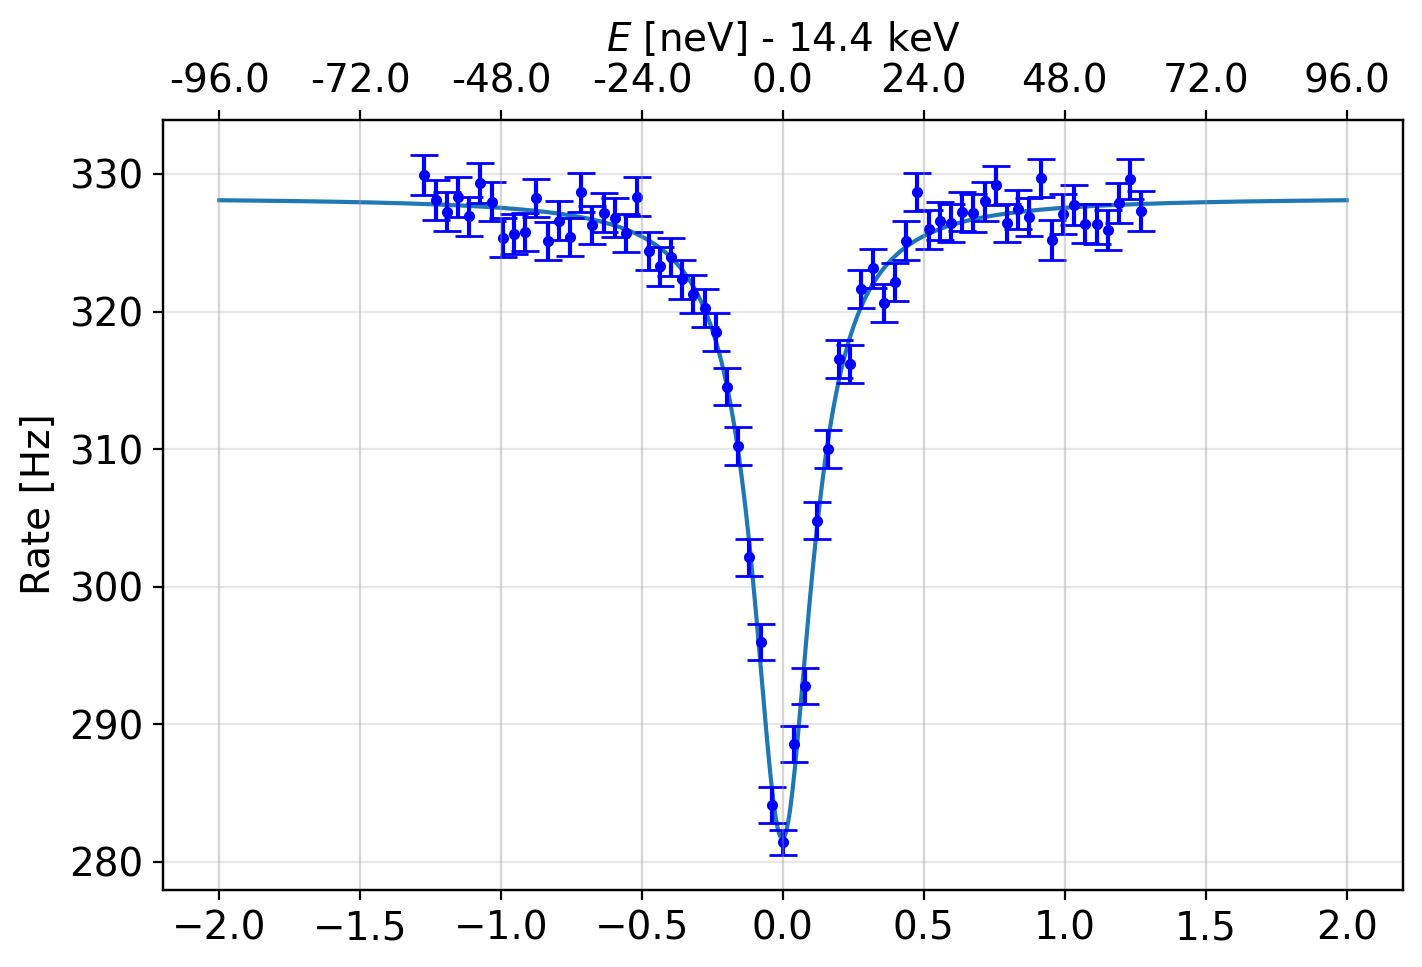

In [87]:

source = CobaltRhodiumMatrix(calibration_activity = 4.3e-3,calibration_date ="20231220")
source = NaturalIronMatrix(calibration_activity = 5e-3,calibration_date ="20231221")  # default activity is the single-line source from chemistry (2.6 mCi on 8/30/2021 decayed till today)
absorber = AlphaIron(abundance=0.022, thickness_microns=10)
#absorber = PotassiumFerrocyanide()

### measurement parameters
PMT_OD = 5  # mm
PMT_distance = 7*25.4  # mm
measurement_parameters = dict(
    acquisition_time=23.7*2*3600,  # (1 month) only really used for sensitivity calculations... maybe should be optional?
    solid_angle_fraction=(PMT_OD / PMT_distance)**2.0 / 16,
    background_rate=130.0,
    detection_efficiency=0.42,  # Be window * cardboard * empirical source rate difference (from background fits)
)

moss = mossbauer.MossbauerMeasurement(
    source,
    absorber,
    measurement_parameters
)


def lorentzian(p,x):
    A, B, E0, Gamma = p
    return 1/np.pi*A*Gamma/((x-E0)**2+Gamma**2)+B


## Data
datadir = '/home/mossbauer/Data/mossbauer_data/'
fname = '20240117_scan/Fe0004_2_mms_33steps_0.5-7in.dat'
data = pd.read_csv(join(datadir, fname))
data = data.groupby(['nominal_velocity']).sum()
rates_m = data['count']/data['DAQ_time']
#rates_m[data.index>0] -= 0.4




fig, ax = plt.subplots(1, 1)


vel = np.linspace(-2, 2, 1000)
#plt.plot(vel, moss.transmitted_spectrum(vel))  # NOTE: derivative doesn't work for multi-line spectra

p0=[-100, 5000, -0.16, 0.16 ]
#p0=[-10, 5000, -0.1, 0.1]


p,dp = u.fit(lorentzian,-data.index.values, rates_m, p0 )
plt.plot(vel, lorentzian(p,vel))



plt.errorbar(
    -data.index.values,
    rates_m,
    yerr=rates_m/np.sqrt(data['count']), 
    fmt='b.',
    capsize=5
)


plt.ylabel('Rate [Hz]')
#plt.ylim(0,5000)

#plt.axvline(-0.040)
#plt.axvline(-0.25)
mossbauer.add_energy_axis(ax)
plt.show()

In [86]:
(280-330)/330, (4200-3950)/4200

(-0.15151515151515152, 0.05952380952380952)

,count,unskimmed_count_2x,DAQ_time,frequency,time
nominal_velocity,,,,,
-1.27200,3927.769231,55335.923077,12.0,2.0000,1.705560e+09
-1.23225,3955.923077,55256.076923,12.0,1.9375,1.705559e+09
-1.19250,3934.461538,55207.307692,12.0,1.8750,1.705559e+09
-1.15275,3910.769231,55018.615385,12.0,1.8125,1.705559e+09
-1.11300,3916.615385,55533.692308,12.0,1.7500,1.705559e+09
...,...,...,...,...,...
1.11300,3922.923077,55533.692308,12.0,1.7500,1.705559e+09
1.15275,3940.230769,55018.615385,12.0,1.8125,1.705559e+09
1.19250,3927.230769,55207.307692,12.0,1.8750,1.705559e+09


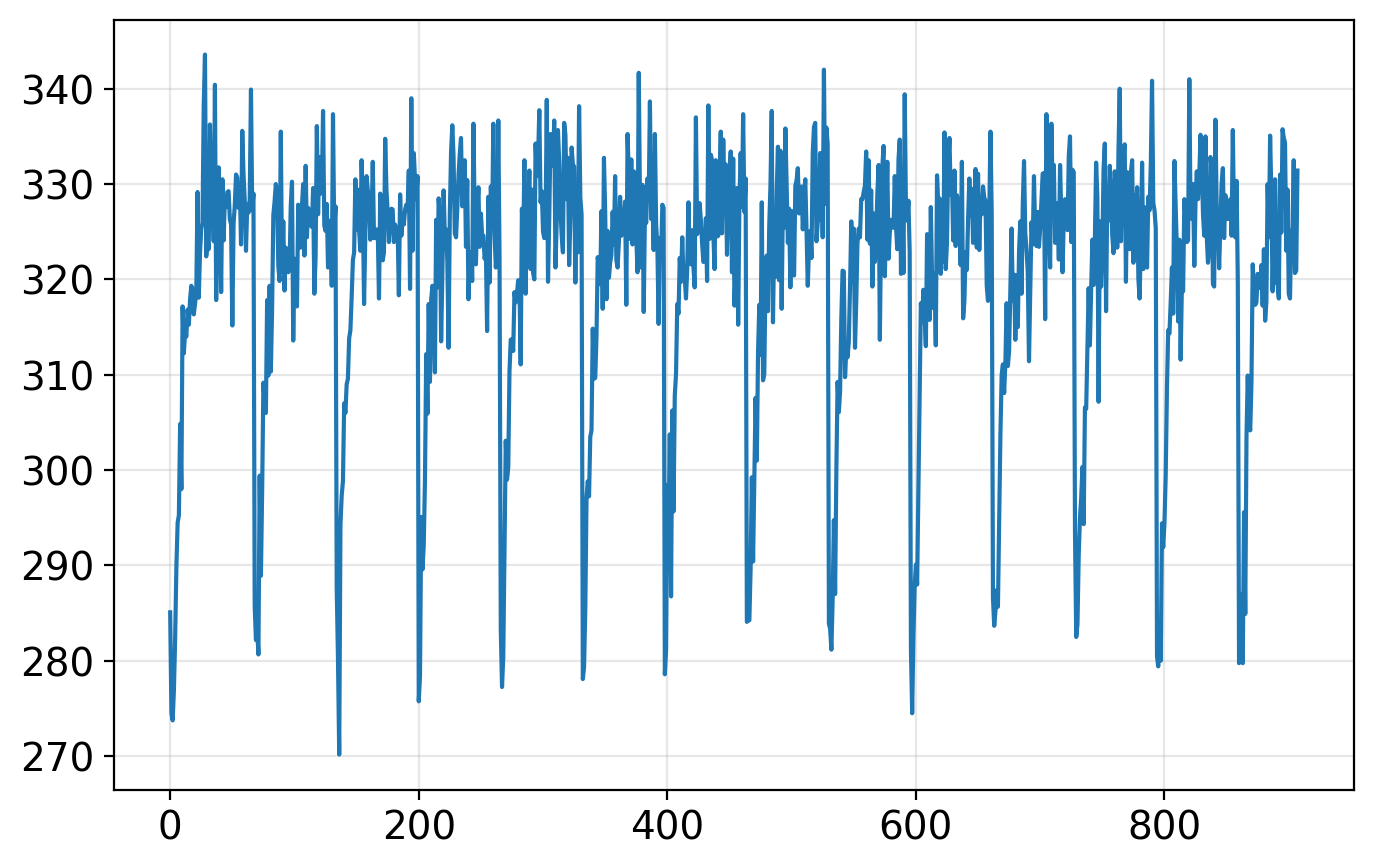

In [74]:
## Data
datadir = '/home/mossbauer/Data/mossbauer_data/'
fname = '20240117_scan/Fe0004_2_mms_33steps_0.5-7in.dat'
data = pd.read_csv(join(datadir, fname))
#data = data.groupby(['nominal_velocity']).sum()
#rates_m = data['count']/data['DAQ_time']
#rates_m[data.index>0] -= 0.4

plt.plot(data['count']/data['DAQ_time'])
data.groupby(['nominal_velocity']).mean()

### CLEANUP 2-POINT SCAN DATA

In [29]:
datadir = '/home/mossbauer/Data/mossbauer_data/'
fname ='20231231_scan/FeCy_0.25_mms_2steps_0.5-1in.dat'
data = pd.read_csv(join(datadir, fname))

idxall = []

vels = data.groupby('nominal_velocity', sort = False).mean().index
times = data.groupby('nominal_velocity', sort = False).mean()['DAQ_time']

todrop = len(data)%len(vels)
data = data.drop(data.tail(todrop).index)

for i,v in enumerate(vels):
    counts = data[data['nominal_velocity']==v]['count'].values
    mean = counts.mean()
    std = counts.std()
    idx = [j for j, c in enumerate(np.abs((counts-mean)/std)) if c>3]
    idx = list(np.array(idx)*len(vels))
    for k in range(len(vels)):
        idxall+=[x+k for x in idx]
    
data = data.drop(idxall)
data.to_csv(datadir + fname[:-4]+'_clean.dat')




### FIRST PLOT AND SENSITIVITY

In [11]:
fname ='20231231_scan/FeCy_0.25_mms_2steps_0.5-1in_clean.dat'
data = pd.read_csv(join(datadir, fname))

#carefu, channels are inverted!
v1 = -0.24804
v2 = -0.03816

counts_v1 = data[data['nominal_velocity']==-v1]['count'].values
counts_v2 = data[data['nominal_velocity']==-v2]['count'].values

timestamps = data[data['nominal_velocity']==-v1]['time'].values
dates=[datetime.datetime.fromtimestamp(ts) for ts in timestamps]
diff = counts_v1/times[-v1]-counts_v2/times[-v2]

fig = plt.figure()
spec = gridspec.GridSpec(ncols=2, nrows=1,
                         width_ratios=[7, 1])

ax1 = fig.add_subplot(spec[0])


ax1.plot(dates, diff,'.',markersize = 1)
plt.xticks(rotation=45, fontsize = 10)
plt.yticks(fontsize = 10)


xfmt = md.DateFormatter('%m-%d', )
ax1.xaxis.set_major_formatter(xfmt)
ax1.xaxis.set_major_locator(md.DayLocator(interval=1))


ax2 = fig.add_subplot(spec[1], sharey = ax1)
h,b, pat  = plt.hist(diff, bins =300,density=True, orientation=u'horizontal',label='difference')
mu, std = norm.fit(diff)
ax2.plot(norm.pdf(np.linspace(-500,500,1000), mu, std), np.linspace(-500,500,1000), color = 'k',linewidth=1)

plt.ylim(min(diff)-10,max(diff)+10)

fig.subplots_adjust(wspace=0.004)
ax2.axis('off')


#ax1.set_xticks(ax1.get_xticks(), rotation=0)

v1 = -0.24804
v2 = -0.03816
dRdE_v1 = moss.transmitted_spectrum_derivative(vels[np.argmin(np.abs(vels-v1))])
dRdE_v2 = moss.transmitted_spectrum_derivative(vels[np.argmin(np.abs(vels-v2))])
dRdE_diff = dRdE_v1 - dRdE_v2

ax1.set_ylabel('$\Delta N$')
ax1.set_xlabel('$date [M-D]$')
plt.show()

mu, std, std/np.sqrt(len(diff))/dRdE_diff/3e11

NameError: name 'times' is not defined

### SENSITIVITY AS A FUNCTION OF TIME

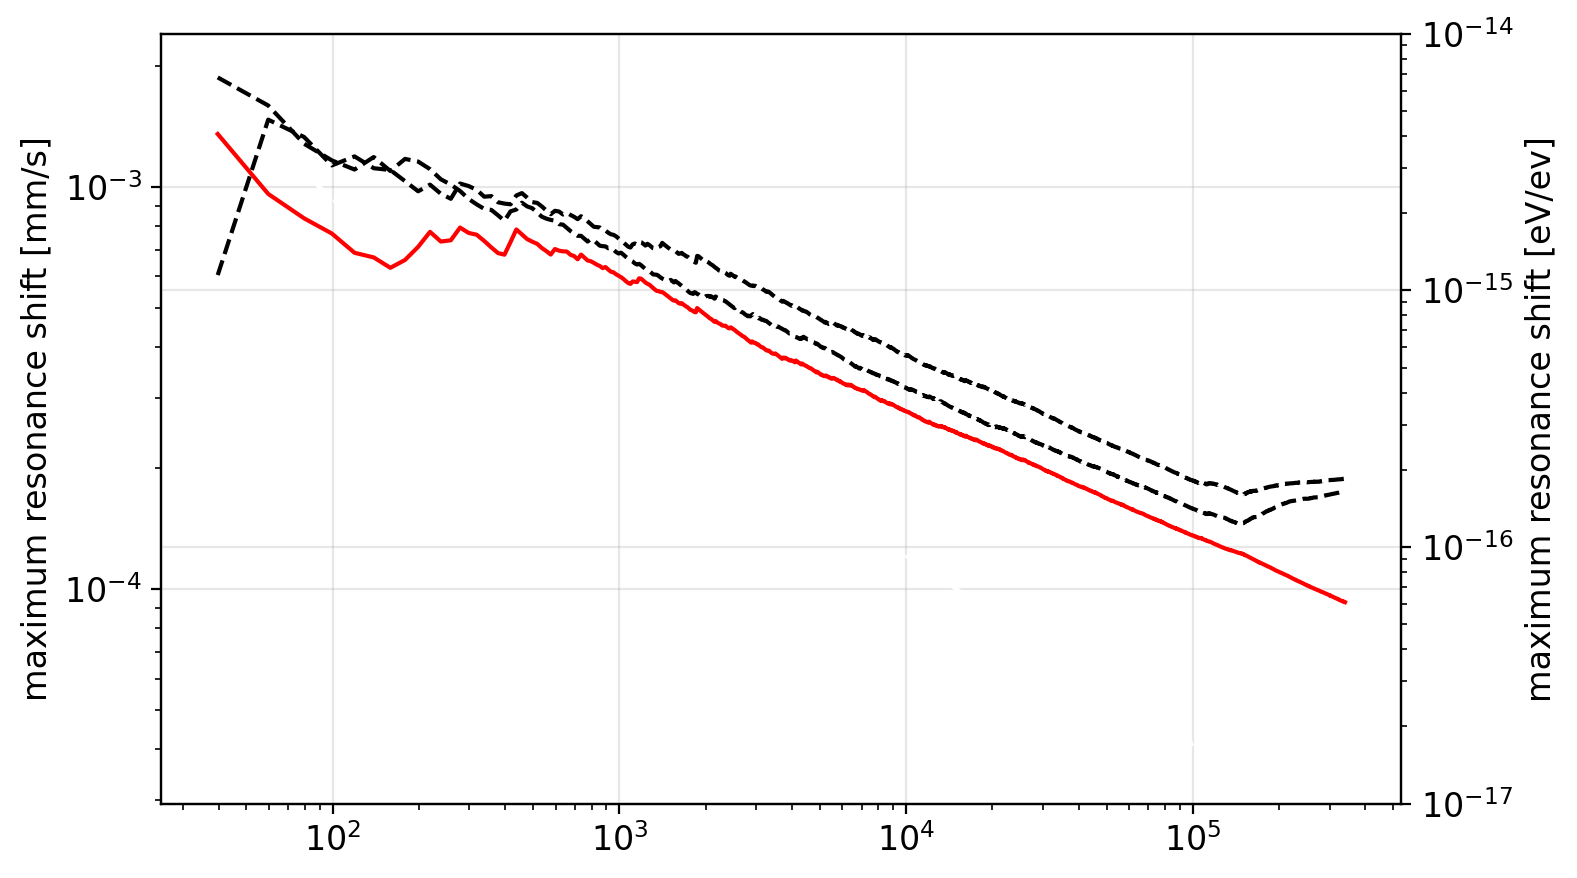

5.931416251049793e-17

In [24]:
fname ='20231231_scan/FeCy_0.25_mms_2steps_0.5-1in_clean.dat'
data = pd.read_csv(join(datadir, fname))

#carefu, channels are inverted!
v1 = -0.24804
v2 = -0.03816

datav1 = data[data['nominal_velocity']==-v1].reset_index()
datav2 = data[data['nominal_velocity']==-v2].reset_index()

    
sigma_rate_v1 = (datav1['count']/datav1['DAQ_time']).expanding().std().values[1:]
sigma_rate_v2 = (datav2['count']/datav2['DAQ_time']).expanding().std().values[1:]
sigma_rate_diff = ((datav1['count']/datav1['DAQ_time']-datav2['count']/datav2['DAQ_time'])).expanding().std().values[1:]

#n = datav1.reset_index().index.values[1:]+1
n = datav1.index.values[1:]+1

delta_rate_v1 = sigma_rate_v1/np.sqrt(n)
delta_rate_v2 = sigma_rate_v2/np.sqrt(n)
delta_rate_diff = sigma_rate_diff/np.sqrt(n)


dt = (datav1['DAQ_time'][1]+datav2['DAQ_time'][1])
time = n*dt


fig, ax = plt.subplots(1, 1)
ax2 = ax.twinx()

vels = np.linspace(-1,1,10000)

dRdE_v1 = moss.transmitted_spectrum_derivative(vels[np.argmin(np.abs(vels-v1))])
dRdE_v2 = moss.transmitted_spectrum_derivative(vels[np.argmin(np.abs(vels-v2))])

dRdE_diff = dRdE_v1 - dRdE_v2


dEmin_v1 = delta_rate_v1/np.abs(dRdE_v1)
dEmin_v2 = delta_rate_v2/np.abs(dRdE_v2)
dEmin_diff = delta_rate_diff/np.abs(dRdE_diff)


ax.loglog(time, dEmin_v1, 'w--',label = 'single point -')
ax2.loglog(time, mossbauer.vel_to_E(dEmin_v1)/14e3, 'k--',label = 'single point 1')
ax2.loglog(time, mossbauer.vel_to_E(dEmin_v2)/14e3, 'k--',label = 'single point 2')
ax2.loglog(time, mossbauer.vel_to_E(dEmin_diff)/14e3, 'r',label = 'diff')
ax2.set_yscale('log')
ax.set_yscale('log')
#plt.fill_between(time, 1/np.sqrt(n)-1/n, 1/np.sqrt(n)+1/n, color='C2',alpha = 0.5)


plt.xlabel('integration time [h]')
ax.set_ylabel('maximum resonance shift [mm/s]')
ax2.set_ylim(1e-17,1e-14)
ax2.set_ylabel('maximum resonance shift [eV/ev]')

plt.show()


np.savetxt(datadir + fname[:-4]+'_sensitivityvstime.dat', [time,mossbauer.vel_to_E(dEmin_diff)/14e3])
mossbauer.vel_to_E(dEmin_diff[-1])/14.4e3


### OTHER PLOTS

Text(0, 0.5, '$dR/dv \\, [Hz/ms^{-1}]$')

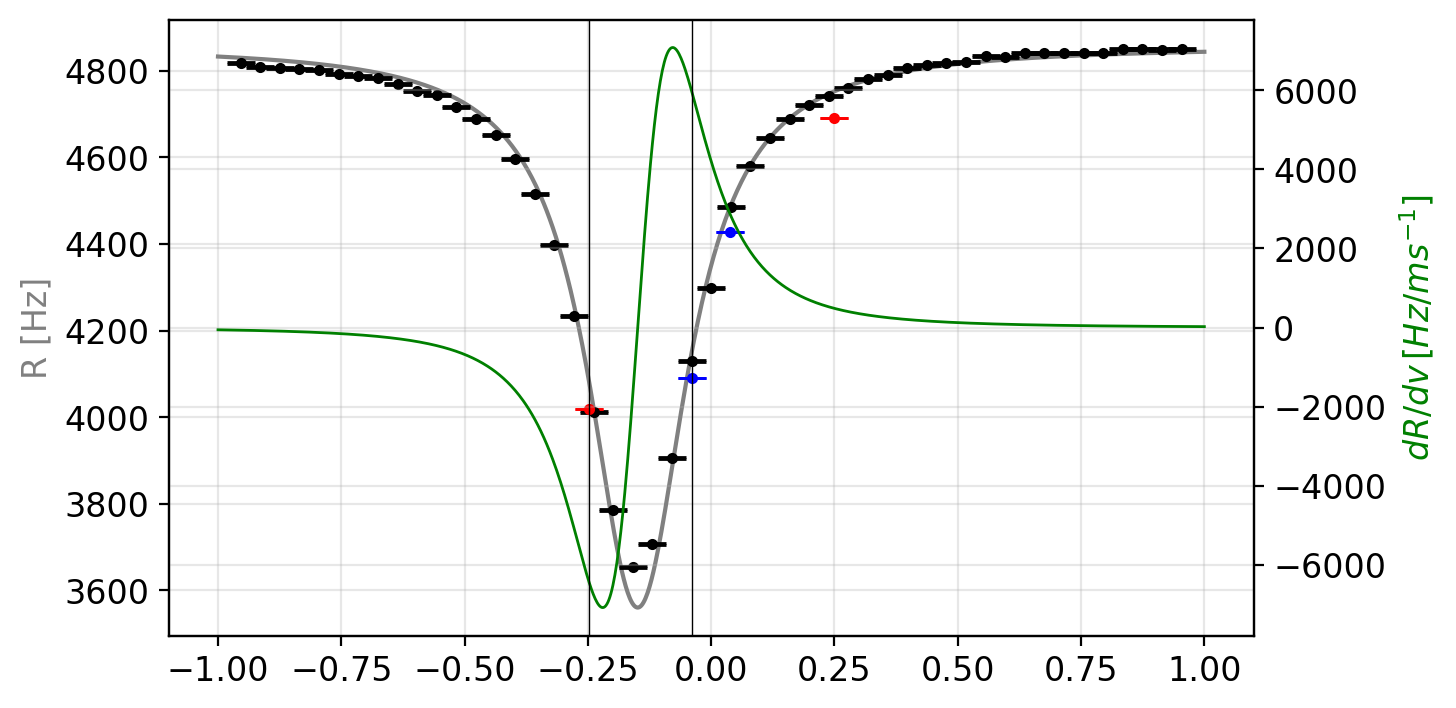

In [196]:
## Data

fig, ax = plt.subplots(1, 1, figsize = (7,4))
plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=12)



ax2 =ax.twinx()

vel = np.linspace(-1, 1, 1000)
dndv = moss.transmitted_spectrum_derivative(vel)

ax.plot(vel, moss.transmitted_spectrum(vel),color = 'gray')  # NOTE: derivative doesn't work for multi-line spectra
ax2.plot(vel , moss.transmitted_spectrum_derivative(vel), color = 'g', linewidth = 1)


datadir = '/home/mossbauer/Data/mossbauer_data/'
fname = '20231230_scan/FeCy_0.25_mms_25steps_0.5-1in.dat'
data = pd.read_csv(join(datadir, fname))
data = data.groupby(['nominal_velocity']).sum()
rates_m = data['count']/data['DAQ_time']
ax.errorbar(
    -data.index.values,
    rates_m,
    yerr=rates_m/np.sqrt(data['count']), 
    fmt='k.',
    capsize=5
)


datadir = '/home/mossbauer/Data/mossbauer_data/'
fname =  '20231231_scan/FeCy_0.25_mms_2steps_0.5-1in_clean.dat'
data = pd.read_csv(join(datadir, fname))
data = data.groupby(['nominal_velocity']).sum()
rates_m = data['count']/data['DAQ_time']

ax.errorbar(
    -data.index.values[::3],
    rates_m[::3],
    yerr=rates_m[::3]/np.sqrt(data['count'][::3]), 
    fmt='r.',
    capsize=5
)

ax.errorbar(
    -data.index.values[1:-1],
    np.array(rates_m)[1:-1],
    yerr=np.array(rates_m)[1:-1]/np.sqrt(np.array(data['count'])[1:-1]), 
    fmt='b.',
    capsize=5
)



v1 = -0.24804
v2 = -0.03816

plt.axvline(v1,color = 'k', linewidth = 0.5)
plt.axvline(v2,color = 'k', linewidth = 0.5)
ax.set_ylabel('R [Hz]',color = 'gray')
ax2.set_ylabel('$dR/dv \, [Hz/ms^{-1}]$', color = 'g')
#ax.set_ylim(400,600)
#ax2.set_ylim(-2000,2000)
#ax.set_yticks([400,450,500,550,600])
#ax2.set_yticks([-2000,-1000,0,1000,2000])

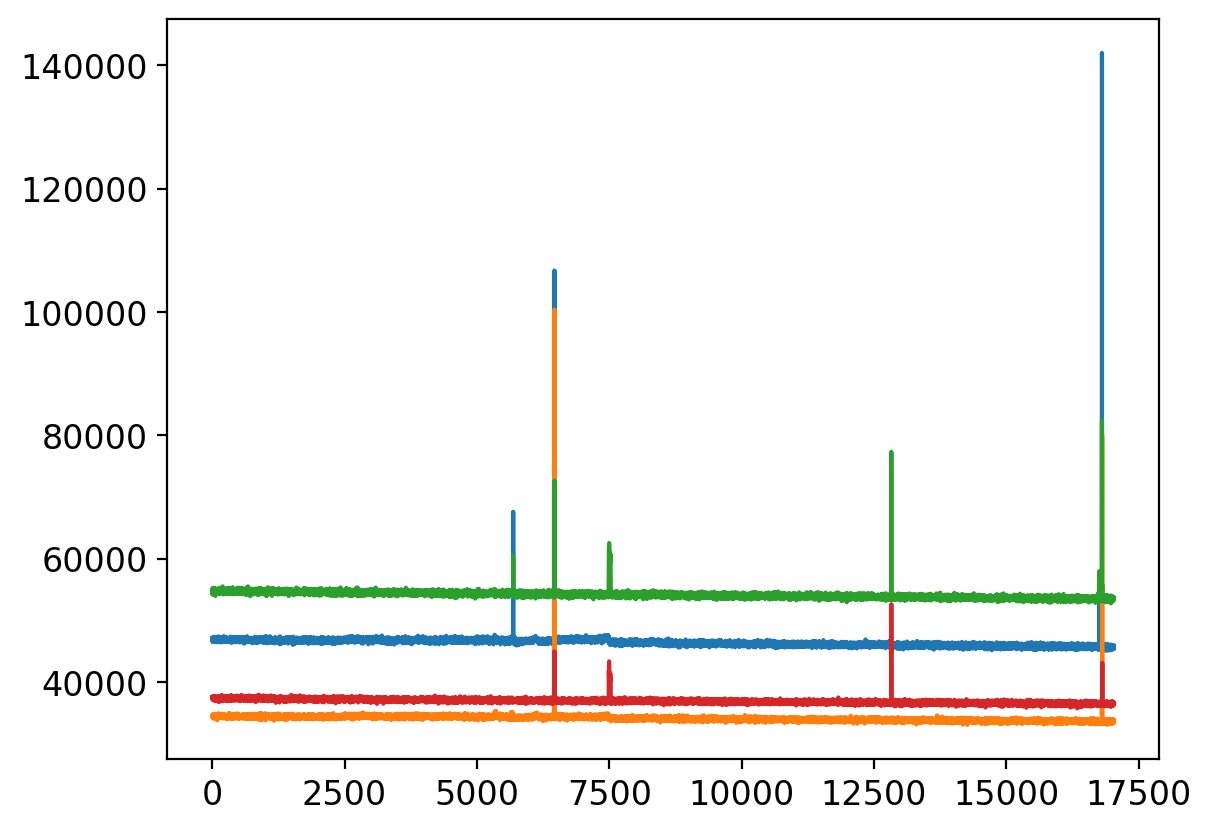

In [83]:
idx1=0
idx2=-1

v1 = -0.24804
v2 = -0.03816

fname ='20231231_scan/FeCy_0.25_mms_2steps_0.5-1in.dat'
data = pd.read_csv(join(datadir, fname))
data = data[idx1:idx2]

#plt.plot(data['count'],'.')

#vels = data.groupby('nominal_velocity').mean().index.values
#for v in vels:
#v = v1

counts_v1 = data[data['nominal_velocity']==-v1]['count'].values
counts_v2 = data[data['nominal_velocity']==-v2]['count'].values

counts_v3 = data[data['nominal_velocity']==v1]['count'].values
counts_v4 = data[data['nominal_velocity']==v2]['count'].values

plt.plot(counts_v1)
plt.plot(counts_v2)
plt.plot(counts_v3)
plt.plot(counts_v4)

#plt.xlim(5600,6000)

In [223]:
data[]

,count,unskimmed_count_2x,DAQ_time,nominal_velocity,frequency,time
0,47106.0,636250.0,11.538462,0.24804,0.39,1.704026e+09
1,54391.0,636250.0,11.538462,-0.24804,0.39,1.704026e+09
2,34500.0,461321.0,8.333333,0.03816,0.06,1.704026e+09
3,37518.0,461321.0,8.333333,-0.03816,0.06,1.704026e+09
4,46814.0,635149.0,11.538462,0.24804,0.39,1.704026e+09
...,...,...,...,...,...,...
33954,34398.0,454486.0,8.333333,0.03816,0.06,1.704736e+09
33955,36837.0,454486.0,8.333333,-0.03816,0.06,1.704736e+09
33956,46756.0,628529.0,11.538462,0.24804,0.39,1.704736e+09
33957,54304.0,628529.0,11.538462,-0.24804,0.39,1.704736e+09


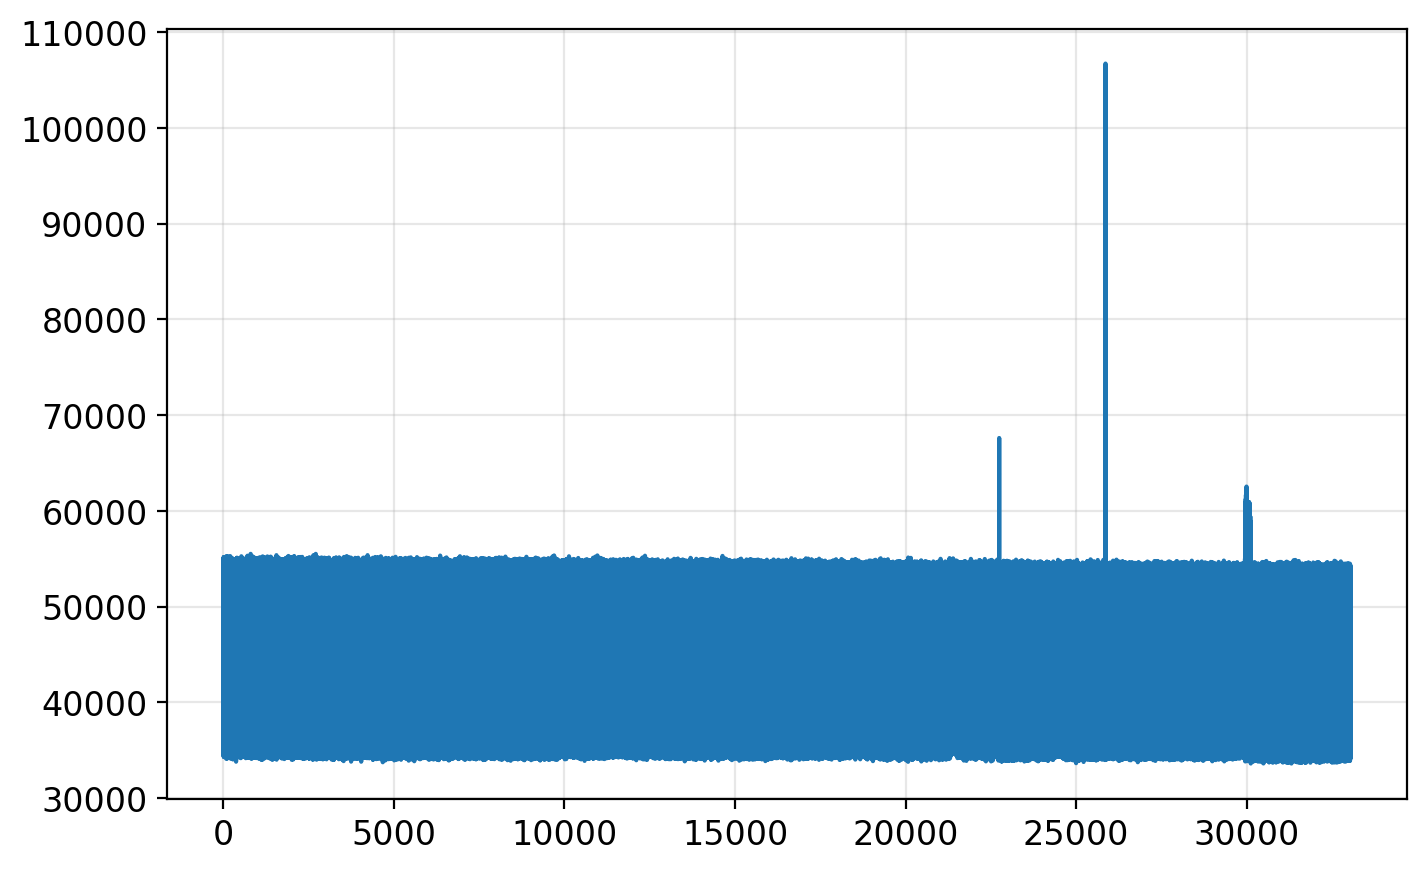

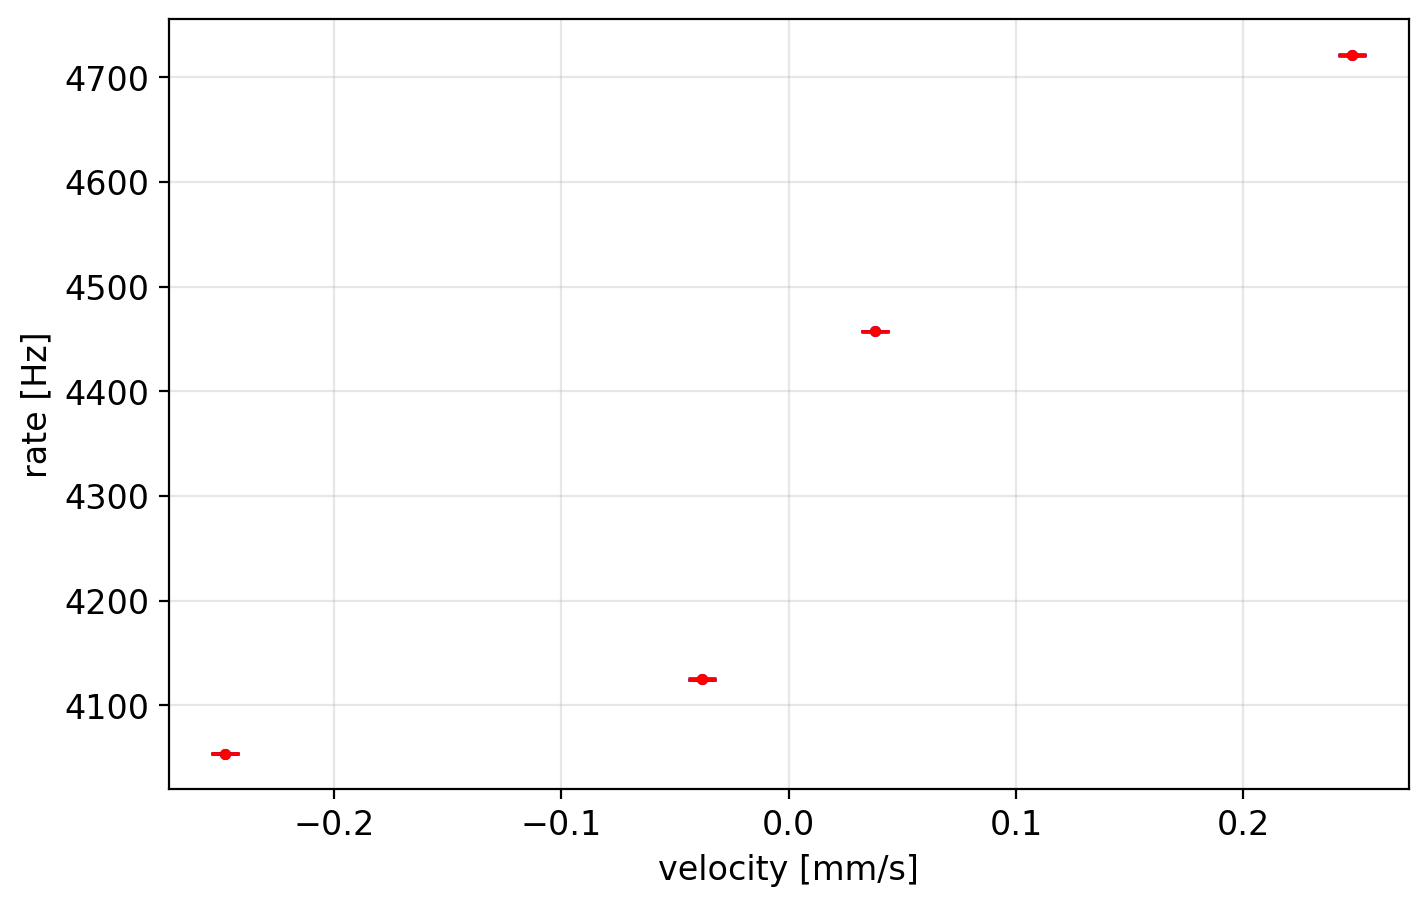

v1 = 4053.76 +/- 6.45e+01, v2 = 4124.81 +/- 9.09e+01


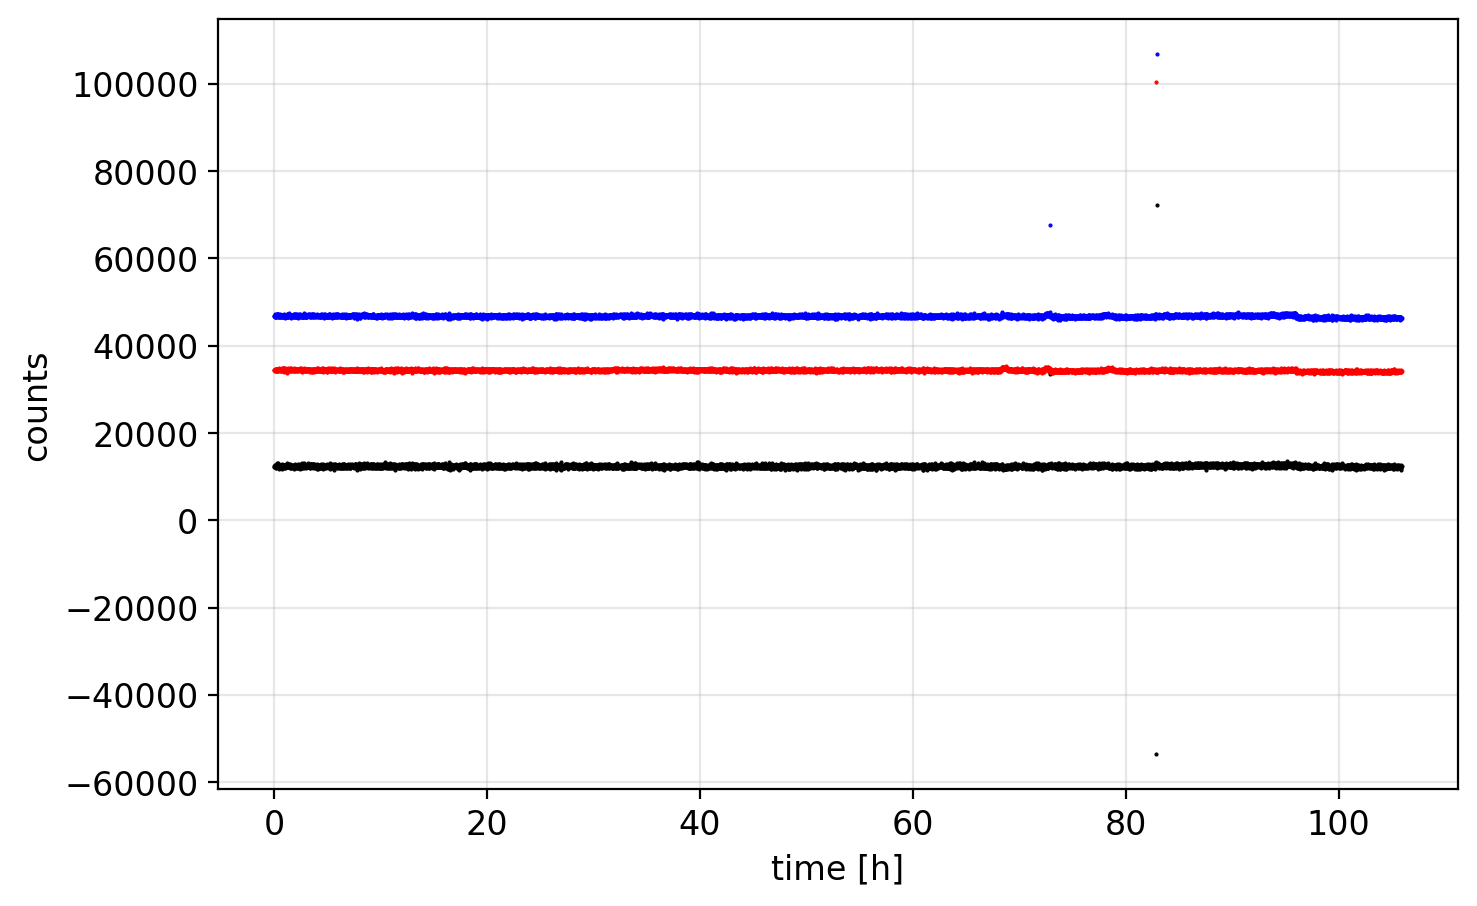

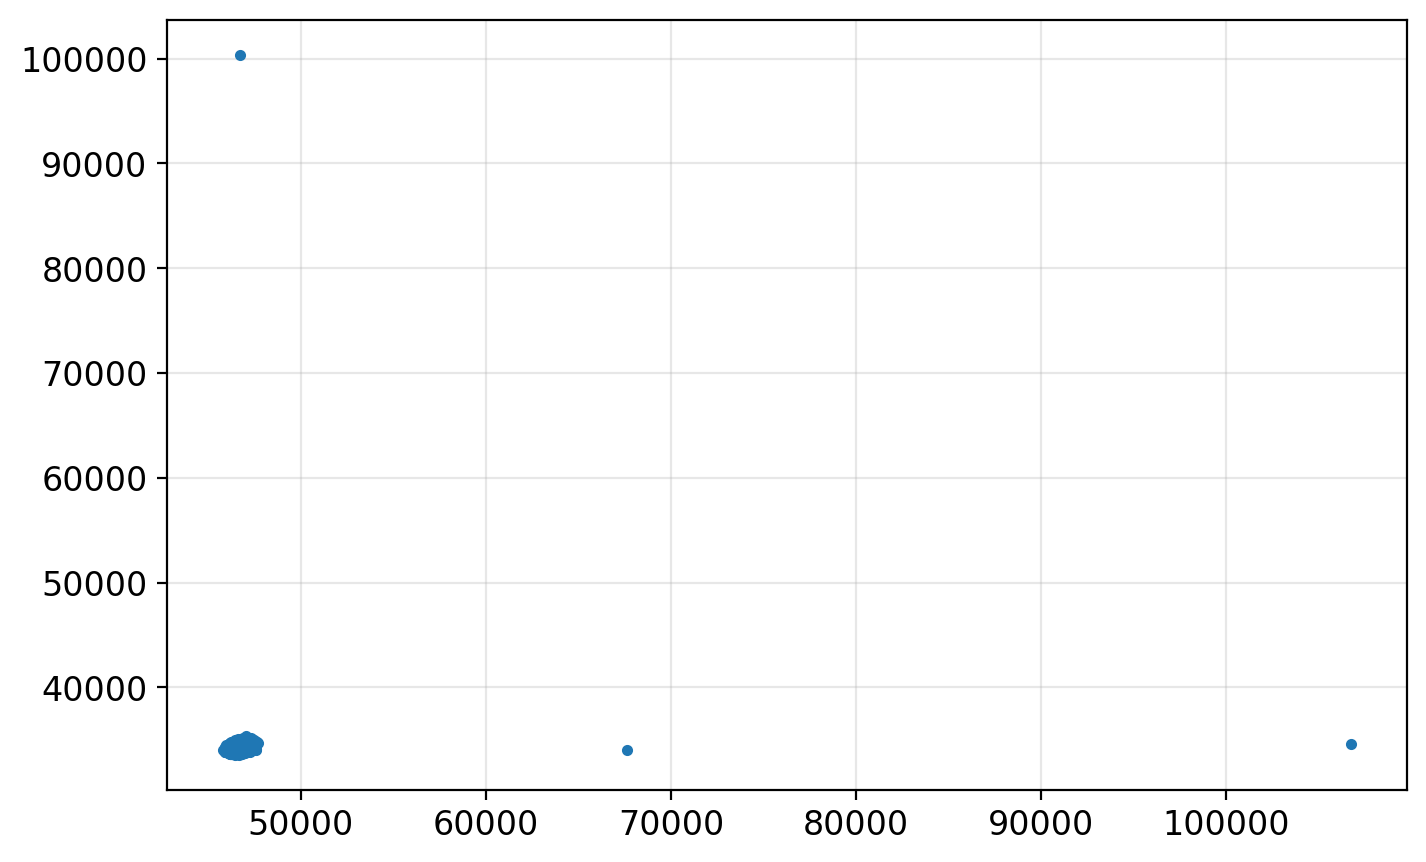

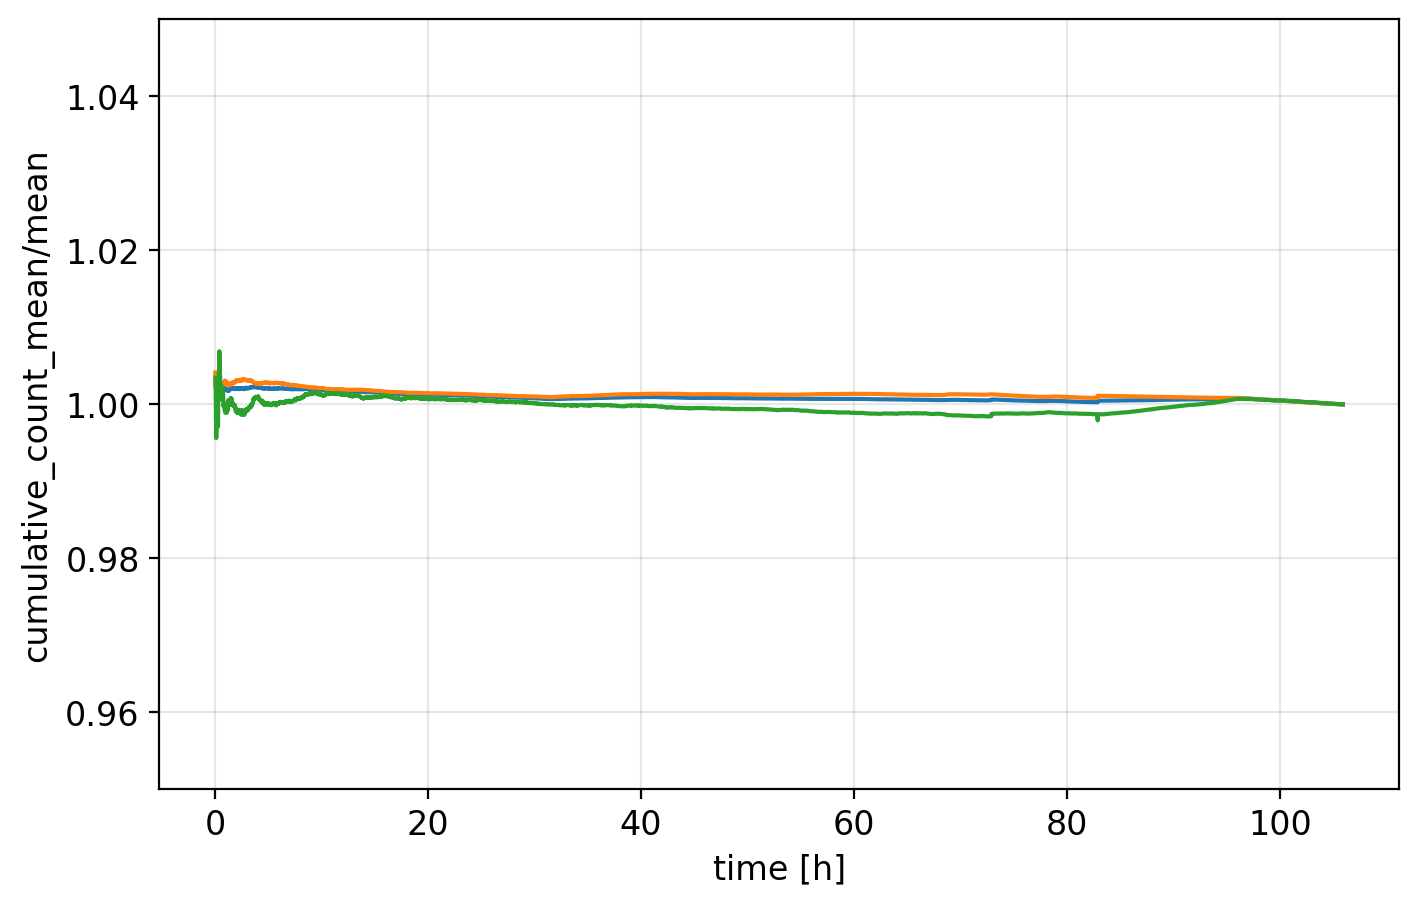

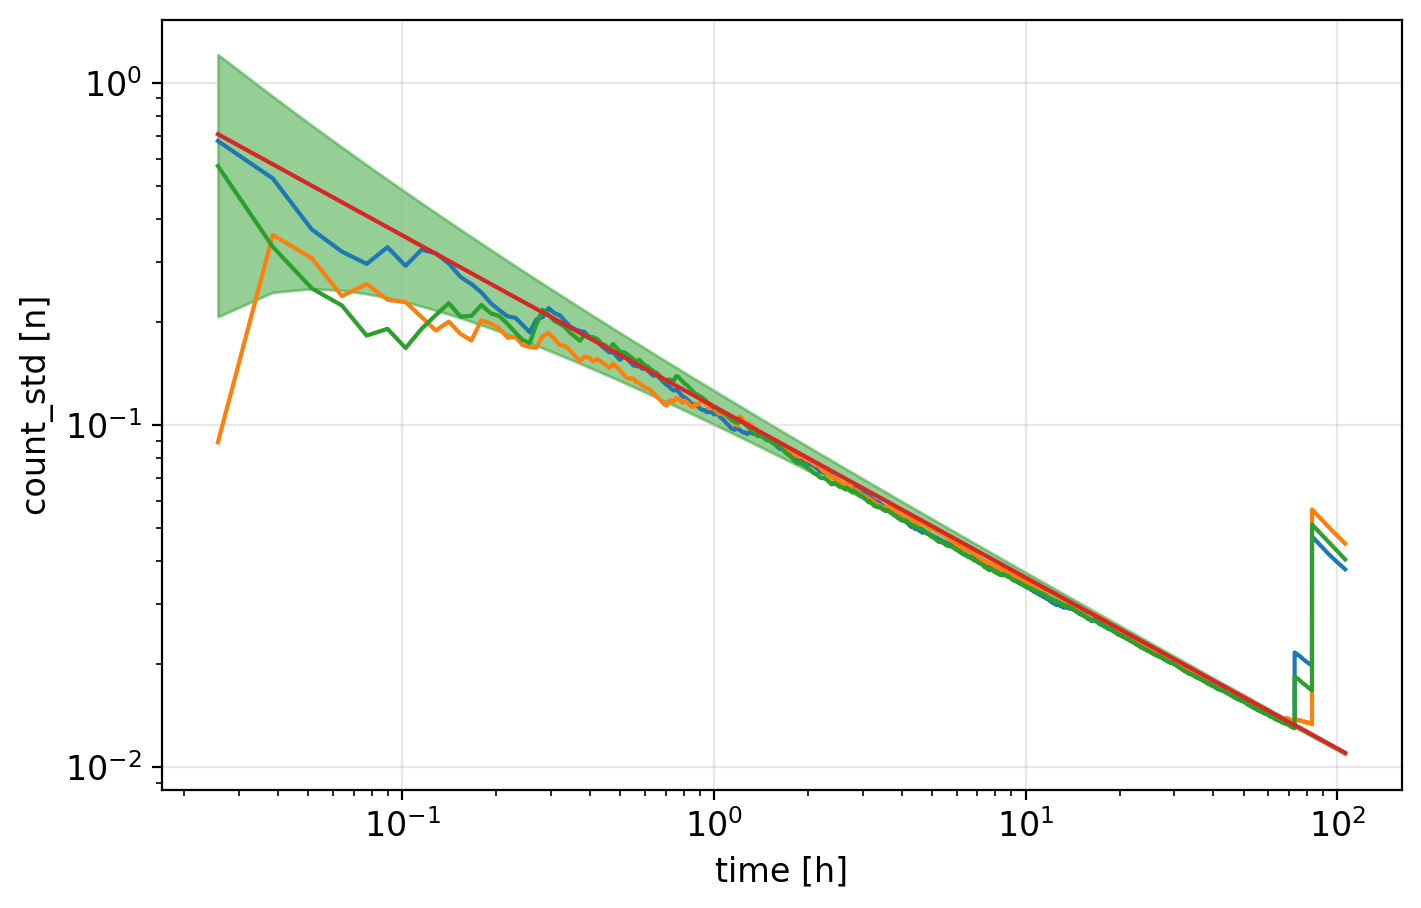

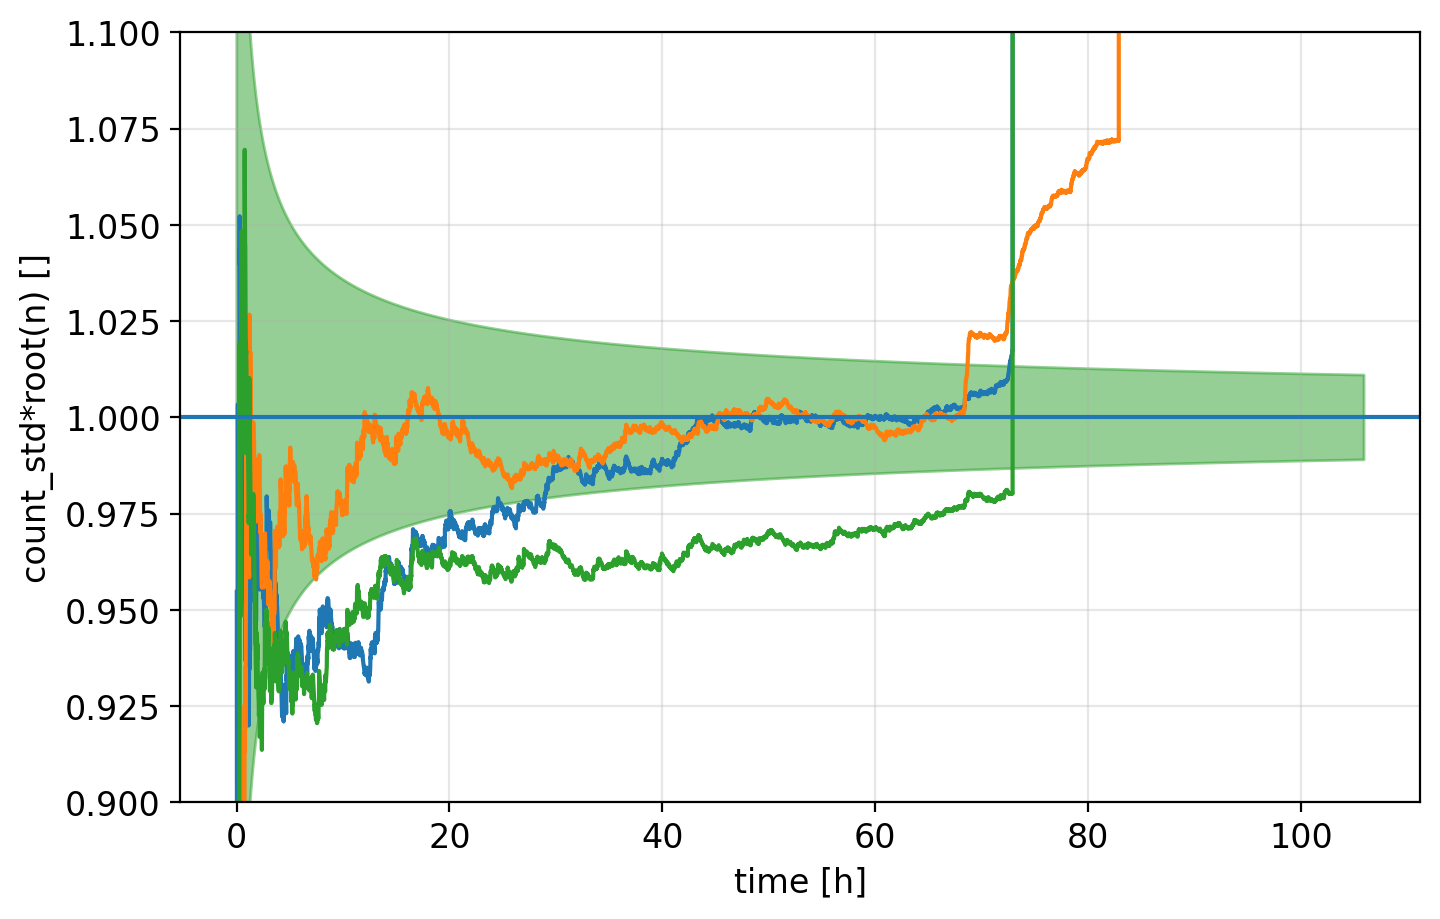

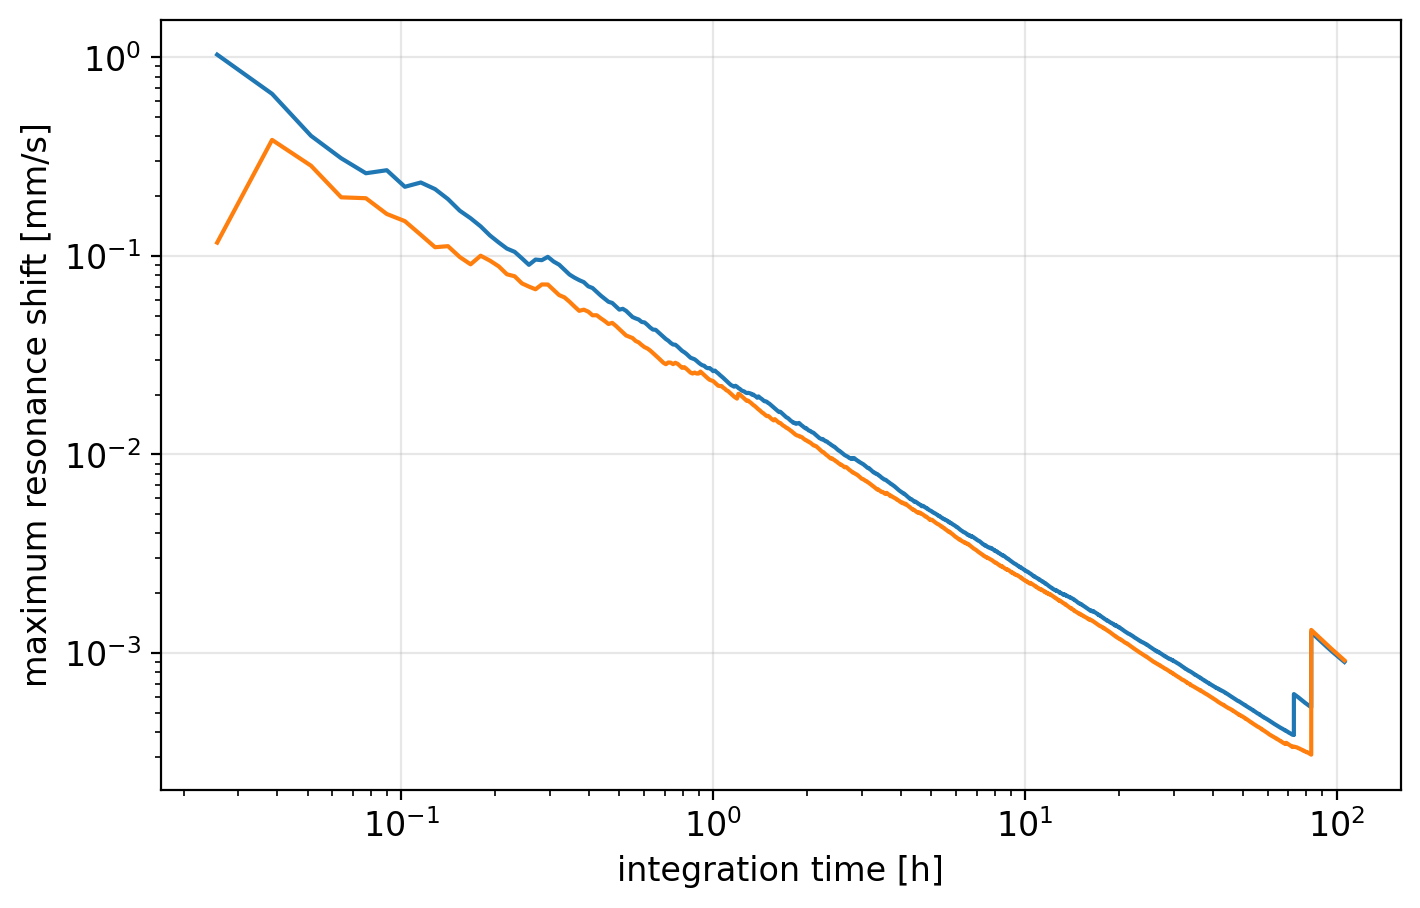

Text(0, 0.5, 'maximum resonance shift $[\\Gamma]$')

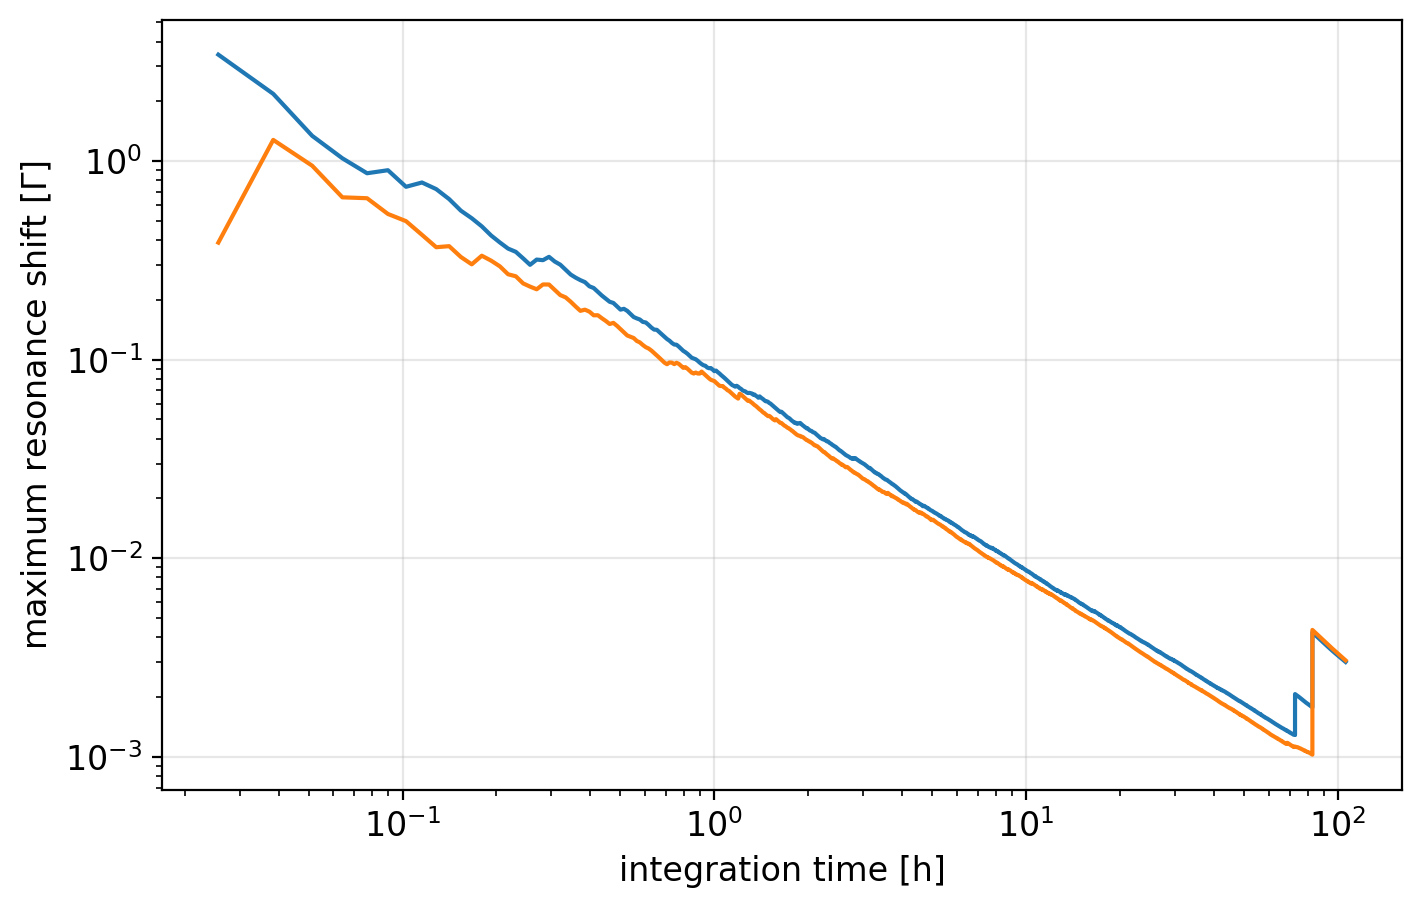

In [183]:
idx1=0
idx2=-1


v1 = -0.24804
v2 = -0.03816

fname ='20231231_scan/FeCy_0.25_mms_2steps_0.5-1in.dat'
data = pd.read_csv(join(datadir, fname))
data = data[idx1:idx2]
#remove outliers
#data = data[(data['count']<4600) & (data['count']>400)]
#data = data[np.abs((data['count']-data['count'].mean()))<8000]
#data = data[data['count']<4600]

plt.plot(data['count'])
plt.show()


data = data.groupby(['nominal_velocity']).sum()
rates = data['count']/data['DAQ_time']

plt.errorbar(
    -data.index.values,
    rates,
    yerr=rates/np.sqrt(data['count']), 
    fmt='b.',
    capsize=5
)


data2 = pd.read_csv(join(datadir, fname))
data2 = data2[idx1:idx2]
 
N = len(data2)
data2 = data2.groupby(['nominal_velocity']).mean()
N = N/len(data2)
rates_mean = data2['count']/data2['DAQ_time']

data3 = pd.read_csv(join(datadir, fname))
data3 = data3[idx1:idx2]
data3 = data3.groupby(['nominal_velocity']).std()
rates_std = data3['count']/data2['DAQ_time']


plt.errorbar(
    -data.index.values,
    rates_mean,
    yerr=rates_std/np.sqrt(N), 
    fmt='r.',
    capsize=5
)


plt.xlabel('velocity [mm/s]')
plt.ylabel('rate [Hz]')
plt.show()


data = pd.read_csv(join(datadir, fname))
data = data[idx1:idx2]
datav1 = data[data['nominal_velocity']==-v1].reset_index()
datav2 = data[data['nominal_velocity']==-v2].reset_index()

minlen = min(len(datav1['count']),len(datav2['count']))

datav1 = datav1[:minlen]
datav2 = datav2[:minlen]
    
meanv1 = datav1['count'].expanding().mean().values[1:]
meanv2 = datav2['count'].expanding().mean().values[1:]
stdv1 = datav1['count'].expanding().std().values[1:]
stdv2 = datav2['count'].expanding().std().values[1:]

mean_delta = (datav1-datav2)['count'].expanding().mean().values[1:]
std_delta = (datav1-datav2)['count'].expanding().std().values[1:]


print("v1 = {:.2f} +/- {:.2e}, v2 = {:.2f} +/- {:.2e}".format(meanv1[-1]/datav1['DAQ_time'][1],
                                                             stdv1[-1]/datav1['DAQ_time'][1],
                                                             meanv2[-1]/datav2['DAQ_time'][1],
                                                             stdv2[-1]/datav2['DAQ_time'][1]))


n = datav1.reset_index().index.values[1:]+1
#N = datav1.reset_index().index.values.cumsum()[1:]
dt = datav1['DAQ_time'][1]*4/3600
dtsec = datav1['DAQ_time'][1]
time = n*dt


    
filter=0

#plt.plot(gaussian_filter(np.abs(datav1-datav2)['count']/mean_delta[-1],filter))
#plt.plot(gaussian_filter(datav1['count']/meanv1[-1],filter))
#plt.plot(gaussian_filter(datav2['count']/meanv2[-1],filter))


plt.plot(time, gaussian_filter((datav1-datav2)['count'],filter)[1:], 'k.', markersize = 1)
plt.plot(time, gaussian_filter(datav1['count'],filter)[1:], 'b.', markersize = 1)
plt.plot(time, gaussian_filter(datav2['count'],filter)[1:], 'r.', markersize = 1)

plt.ylabel("counts")
plt.xlabel("time [h]")

plt.show()

plt.plot(datav1['count'].values,datav2['count'].values,'.')
#plt.plot(datav1['count']/dtsec,datav2['count']/dtsec,'.')
plt.show()

plt.plot(time,meanv1/meanv1[-1])
plt.plot(time,meanv2/meanv2[-1])
plt.plot(time,mean_delta/mean_delta[-1])
plt.ylim(0.95,1.05)

plt.ylabel("cumulative_count_mean/mean")
plt.xlabel("time [h]")

plt.show()


plt.loglog(time,stdv1/np.sqrt(n)/np.sqrt(meanv1[-1]))
plt.loglog(time,stdv2/np.sqrt(n)/np.sqrt(meanv2[-1]))
plt.loglog(time,std_delta/np.sqrt(n)/np.sqrt(meanv1[-1]+meanv2[-1]))
plt.loglog(time, 1/(np.sqrt(n)))


#plt.loglog(timev2[1:]*dt,deltav2[1:]/np.sqrt(meanv2[-1]))
#plt.loglog(timev2[1:]*dt, 1/(np.sqrt(timev2[1:])))


plt.fill_between(time, 1/np.sqrt(n)-1/n, 1/np.sqrt(n)+1/n, color='C2',alpha = 0.5)

plt.ylabel("count_std [n]")
plt.xlabel("time [h]")


plt.show()



plt.plot(time,stdv1/np.sqrt(meanv1[-1]))
plt.plot(time,stdv2/np.sqrt(meanv2[-1]))
plt.plot(time,std_delta/np.sqrt(meanv1[-1]+meanv2[-1]))

plt.axhline(1)
plt.fill_between(time, 1-1*np.sqrt(n)/n, 1+1*np.sqrt(n)/n, color='C2',alpha = 0.5)


plt.ylim(0.9,1.1)
plt.ylabel("count_std*root(n) []")
plt.xlabel("time [h]")


plt.show()



dndv = (185-170)/0.15
dn1 = stdv1/n
dn2 = stdv2/n

plt.loglog(time,dn1/dndv, label = 'single point +')
plt.loglog(time,dn2/dndv, label = 'single point -')

plt.xlabel('integration time [h]')
plt.ylabel('maximum resonance shift [mm/s]')

plt.show()

datav1['count'].expanding().std().values#-np.array(meanv1)
datav1.reset_index().index.values.cumsum()
(datav1-datav2)['count']
stdv1
len(time),len(meanv1), n
(meanv1[-1]+meanv2[-1])/mean_delta[-1]
time[-1]
65-42


dn = (195-165) 
dn1 = stdv1/n
dn2 = stdv2/n

plt.loglog(time,dn1/dn, label = 'single point +')
plt.loglog(time,dn2/dn, label = 'single point -')

plt.xlabel('integration time [h]')
plt.ylabel('maximum resonance shift $[\Gamma]$')



In [121]:
#data = data[data['count']-data['count'].mean()<]
data['count']-data['count'].mean()

nominal_velocity
-0.03816    0.0
Name: count, dtype: float64

In [50]:
#plt.plot(sigma_rate_diff)
#plt.plot(sigma_rate_v1)
#plt.plot(sigma_rate_v2)
#time[-1]/4
data['DAQ_time'].sum()/3600/4
15**2

225

You can also look at the info of the source and absorber alone

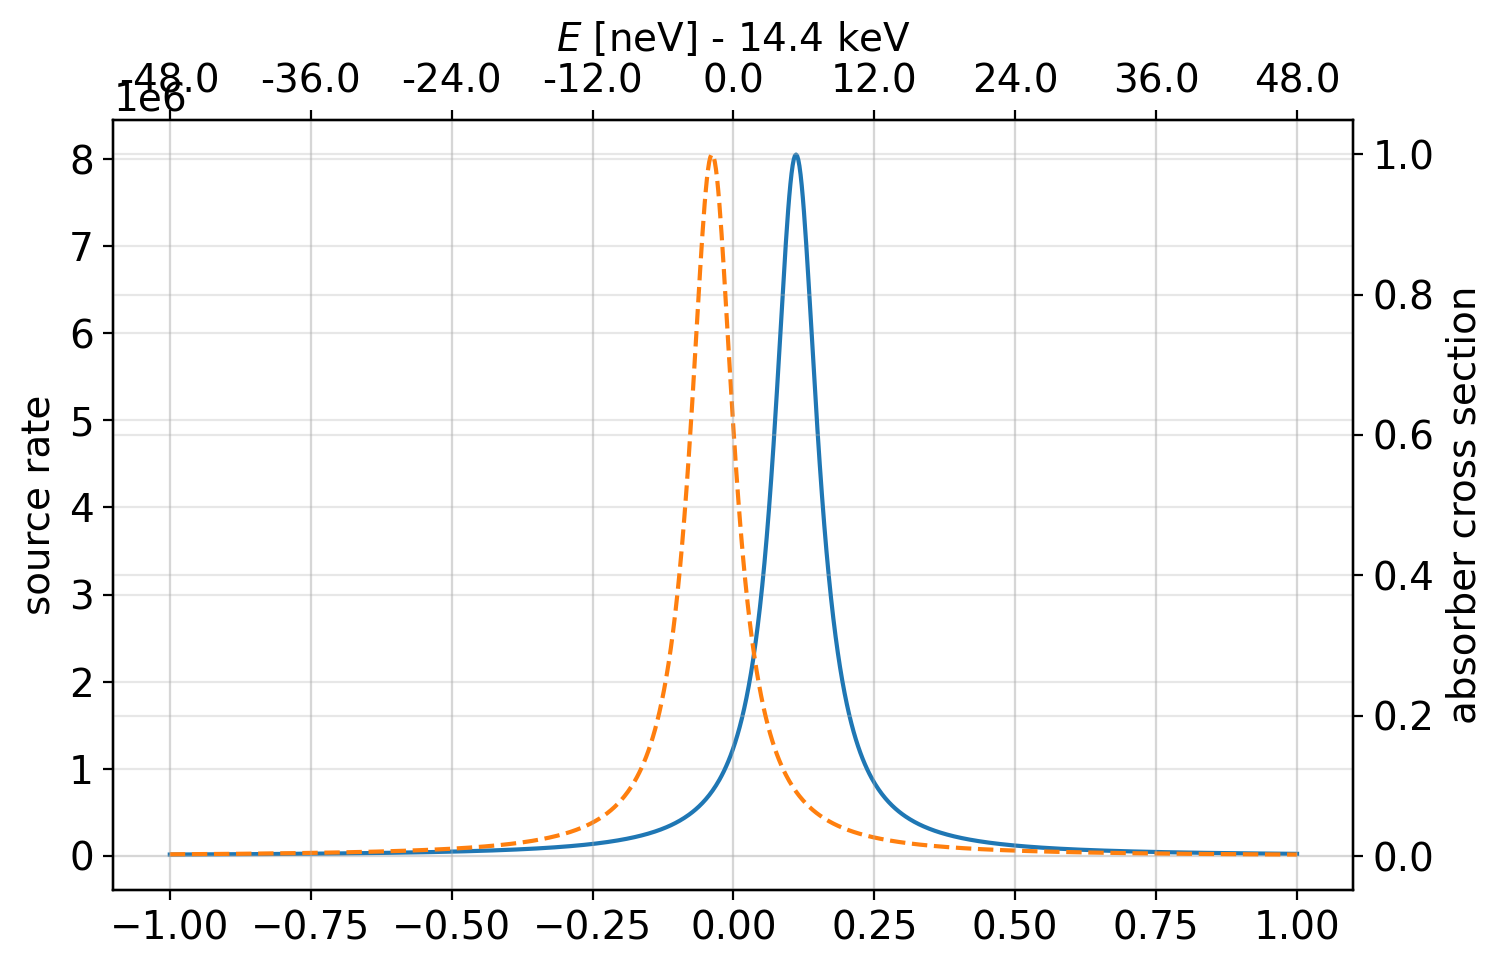

In [51]:
fig, ax = plt.subplots(1, 1)
plt.plot(vel, source.spectrum(vel))
plt.ylabel('source rate')
ax2 = ax.twinx()
plt.plot(vel, absorber.cross_section(vel), 'C1--')
plt.ylabel('absorber cross section')
plt.xlabel('vel [mm/s]')
mossbauer.add_energy_axis(ax)
plt.show()

### Check deltaEmin as a function of measurement velocity

In [52]:
mossbauer_relative_intensity = 0.0916
source_recoilless_fraction = 1.0
source_activity_Hz = 3.7e10 * 0.1  # 100 mCi

acquisition_time =  0.1 * 24 * 31  # 1 month


### source parameters
source_parameters = dict(
    Eres=0.0,
    linewidth=mossbauer.E_to_vel(mossbauer.Fe57_natural_linewidth),
    total_activity=source_activity_Hz * mossbauer_relative_intensity * source_recoilless_fraction
)


### absorber parameters
recoilless_fraction_A = 1.
t_mgcm2 = 0.13  # potassium ferrocyanide from ritverc
absorption_coefficient = 25.0  # cm^2 / mgFe57  (doublecheck)
absorber_parameters = dict(
    Eres=0.0,
    linewidth=mossbauer.E_to_vel(mossbauer.Fe57_natural_linewidth),
    thickness_normalized=t_mgcm2 * absorption_coefficient * recoilless_fraction_A
)

### measurement parameters
PMT_OD = 2 * 2.54  # cm
PMT_distance = 10  # cm
solid_angle_fraction = (PMT_OD / PMT_distance)**2.0 / 16
measurement_parameters = dict(
    acquisition_time=acquisition_time,
    solid_angle_fraction=solid_angle_fraction,
    detection_efficiency=1.0
)

moss = mossbauer.MossbauerMeasurement(
    source_parameters,
    absorber_parameters,
    measurement_parameters
)

### Thickness broadening

In [14]:
ts = np.logspace(-2, 2, 100)
deltaE_opt = np.zeros_like(ts)

for i, t in enumerate(tqdm(ts)):
    moss.absorber.thickness_normalized = t
    # the linear approximation works pretty well for this, but doing full just to check
    #ans = moss.get_deltaEmin_linear()#vels=np.logspace(-4, 0, 1000), acquisition_time=acquisition_time)
    ans = moss.get_deltaEmin_full()
    deltaE_opt[i] = mossbauer.vel_to_E(ans[2])

moss.absorber.thickness_normalized = t_mgcm2 * absorption_coefficient * recoilless_fraction_A

100%|██████████| 100/100 [00:56<00:00,  1.78it/s]


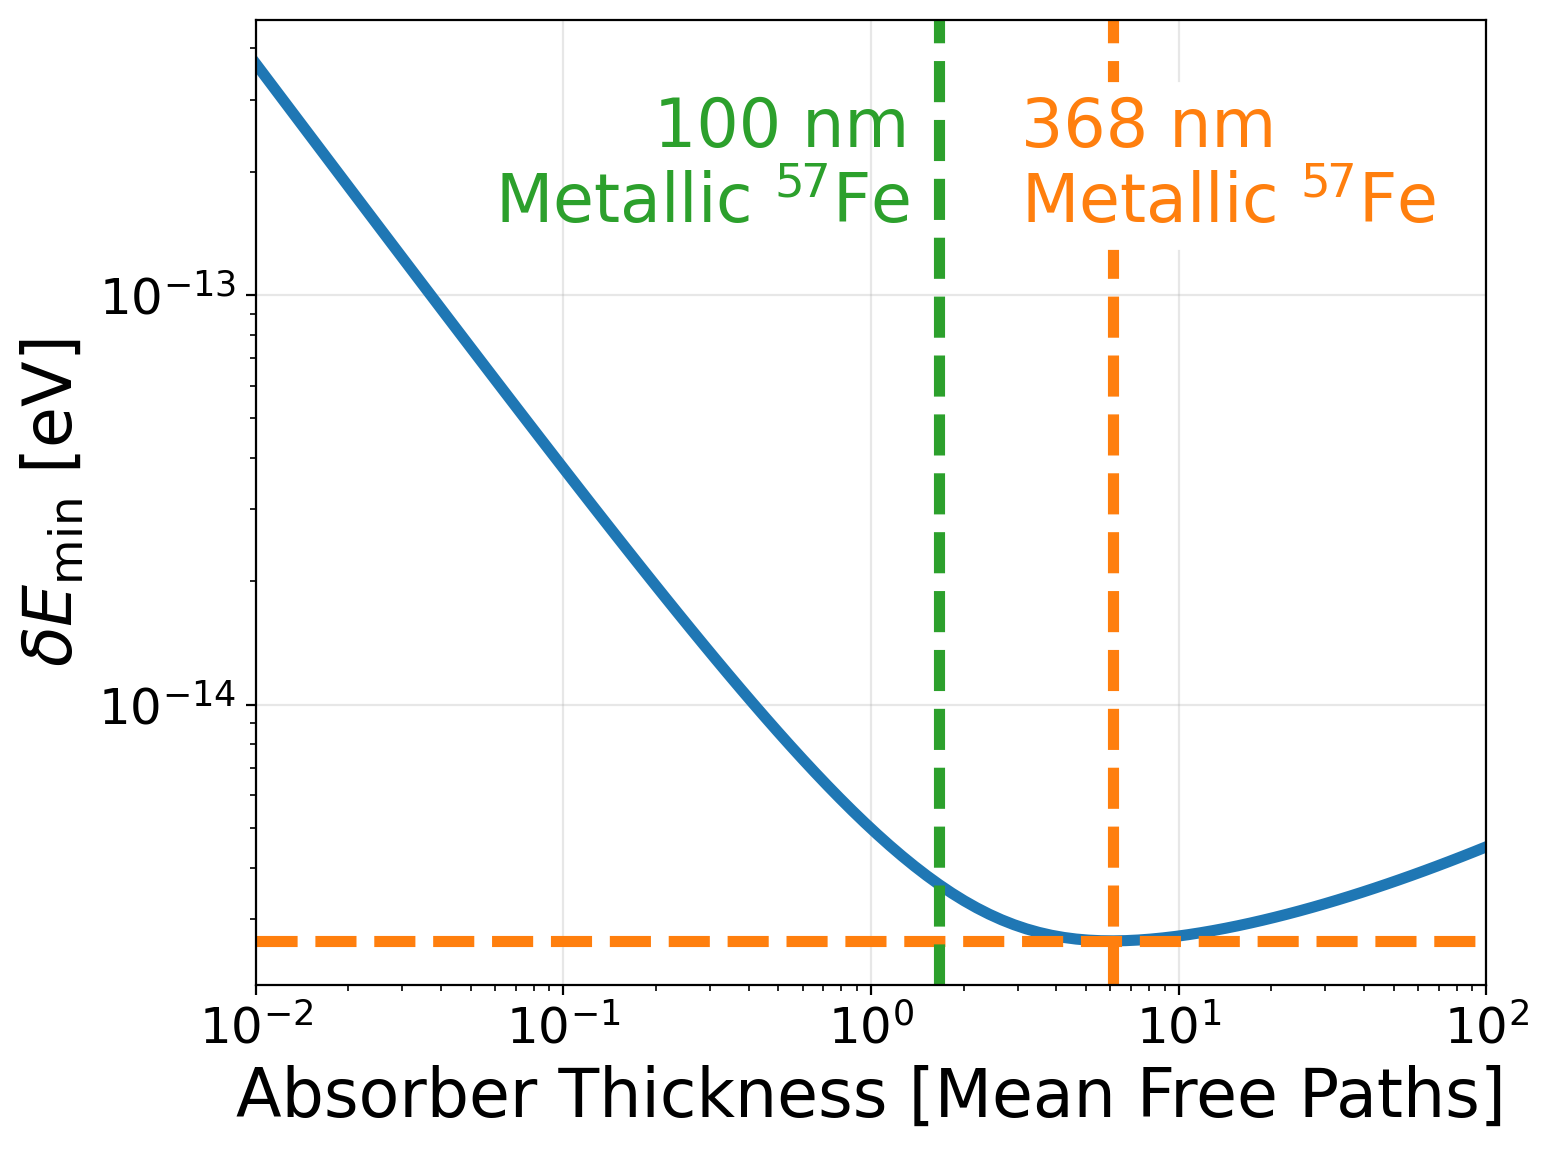

In [15]:
t_exp = (100./48)*0.8
#plt.plot(ts, deltaE, lw=3)
fig, ax = plt.subplots(figsize=(8, 6))
fsize = 24
plt.plot(ts, deltaE_opt, lw=4)
tmin = ts[np.argmin(deltaE_opt)]
plt.axvline(tmin, color='C1', linestyle='--', lw=4)
plt.axhline(deltaE_opt.min(), color='C1', linestyle='--', lw=4)
plt.annotate('%d nm\nMetallic $^{57}$Fe' % (tmin * 48/.8), (tmin*0.5, 1.5e-13), color='C1', fontsize=fsize, bbox=dict(color='w'))
plt.axvline(t_exp, color='C2', linestyle='--', lw=4)
plt.annotate('100 nm\nMetallic $^{57}$Fe' , (t_exp*0.8, 1.5e-13), color='C2', ha='right', fontsize=fsize)
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'Absorber Thickness [Mean Free Paths]', fontsize=fsize)
plt.ylabel(r'$\delta E_\mathrm{min}$ [eV]', fontsize=fsize)

ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)
plt.xlim([0.01, 100])
plt.tight_layout()
if False:
    plt.savefig('plots/effective_absorber_thickness_vs_sensitivity.png')
plt.show()

### Sensitivity

The sensitivity calculation is sequestered in `physics.py` because its a bit of a black box how to go from $\delta E$ to this space. I've mostly filed all this under the title "physics" and left it to Surjeet. In my opinion it anyway makes the most sense to compare sensitivities in terms of $\delta E$ directly, as this is our actual experimental observable. And this calculation also comes from the above `MossbauerMeasurement.get_deltaEmin_full()`.

But for proposals and stuff, I took the function below from Surjeet.

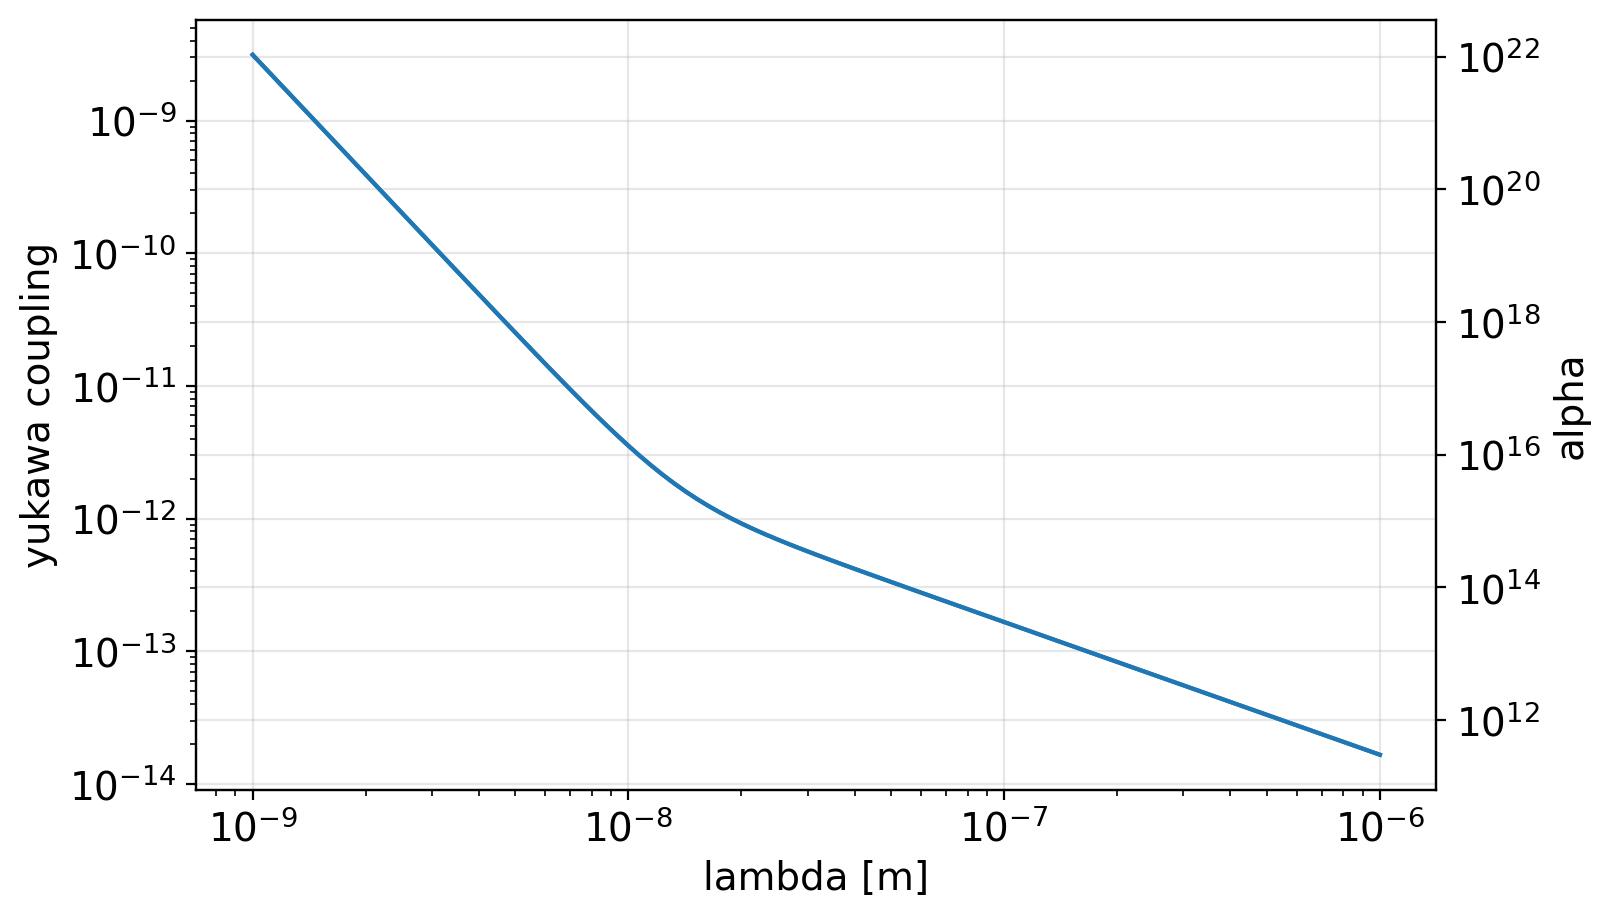

In [16]:
deltaEmin = mossbauer.vel_to_E(moss.get_deltaEmin_full()[2])  # actual experimental observable
r, (yuk, alpha) = moss.get_sensitivity(deltaEmin, 'down_quark')  # physics function from Surjeet

fig, ax = plt.subplots(1, 1)
plt.plot(r, yuk)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('lambda [m]')
plt.ylabel('yukawa coupling')

ax2 = ax.twinx()
plt.yscale('log')
plt.ylabel('alpha')
plt.plot(r, alpha)

plt.show()